# Imports e variáveis globais

In [1]:
%%capture
!pip install pandas
!pip install sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print('Tensorflow version {}'.format(tf.__version__))

Tensorflow version 2.1.0


Algumas variáveis globais para auxiliar no fine-tunning sem ter que procurá-las pelo código.

In [3]:
vocab_size = 50
oov_token = '<OOV>'
padding_type = 'post'
trunc_type = 'post'
padding_max_len = 25
embedding_dim = 8
num_epochs = 50

# Manipulação dos dados

In [4]:
data = pd.read_csv('data.csv', sep=';')
data.head()

,url,text,is_birthday
0,https://twitter.com/Vitoriaa_gabi/status/12484...,Minha madrinha antes de morrer me prometeu uma...,0
1,https://twitter.com/FranceResende/status/12484...,Descobri pq hoje é meu aniversário de twitter ...,1
2,https://twitter.com/Maira1440/status/124842419...,@DjPedroSampaio #LivePedroSampaio HOJE É MEU A...,1
3,https://twitter.com/milenasuisso/status/124842...,MEU ANIVERSÁRIO NÃO É HOJE PEDRO MAS QUERIA VC...,0
4,https://twitter.com/Littlenamjoonie/status/124...,"@moonsjoon PARABÉNS PRA MINHA NAMJOONAAAAA, me...",0


In [5]:
sentences = data['text']
urls = data['url']
is_birthday = data['is_birthday']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    sentences, 
    is_birthday, 
    shuffle=True, 
    random_state=42,
    stratify=is_birthday
)

print("Train set tem {} linhas.\nTest set tem {} linhas.".format(X_train.shape[0], X_test.shape[0]))

Train set tem 445 linhas.
Test set tem 149 linhas.


# Word embeddings

In [7]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [8]:
# Train sequences
sequences = tokenizer.texts_to_sequences(X_train)
padded = pad_sequences(sequences, padding=padding_type, truncating=trunc_type, maxlen=padding_max_len)

# Test sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, padding=padding_type, truncating=trunc_type, maxlen=padding_max_len)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=padding_max_len),
#     If the data is big enough, uncomment the LSTM steps below and remove the Flatten step
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#     tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 8)             400       
_________________________________________________________________
bidirectional (Bidirectional (None, 25, 256)           140288    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               164352    
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 308,161
Trainable params: 308,161
Non-trainable params: 0
_________________________________________________________________


In [10]:
history = model.fit(padded, y_train, epochs=num_epochs, validation_data=(testing_padded, y_test));

Train on 445 samples, validate on 149 samples
Epoch 1/50
445/445 [==============================] - 12s 26ms/sample - loss: 0.5938 - accuracy: 0.7955 - val_loss: 0.4896 - val_accuracy: 0.7919
Epoch 2/50
445/445 [==============================] - 2s 4ms/sample - loss: 0.4858 - accuracy: 0.7955 - val_loss: 0.4648 - val_accuracy: 0.7919
Epoch 3/50
445/445 [==============================] - 2s 4ms/sample - loss: 0.4264 - accuracy: 0.7843 - val_loss: 0.4438 - val_accuracy: 0.7450
Epoch 4/50
445/445 [==============================] - 2s 4ms/sample - loss: 0.4059 - accuracy: 0.8202 - val_loss: 0.4485 - val_accuracy: 0.7919
Epoch 5/50
445/445 [==============================] - 2s 5ms/sample - loss: 0.3943 - accuracy: 0.8225 - val_loss: 0.4365 - val_accuracy: 0.7785
Epoch 6/50
445/445 [==============================] - 2s 5ms/sample - loss: 0.3706 - accuracy: 0.8315 - val_loss: 0.4177 - val_accuracy: 0.7450
Epoch 7/50
445/445 [==============================] - 2s 5ms/sample - loss: 0.3733 - acc

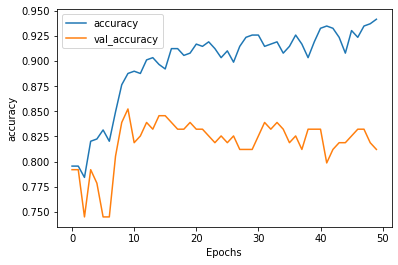

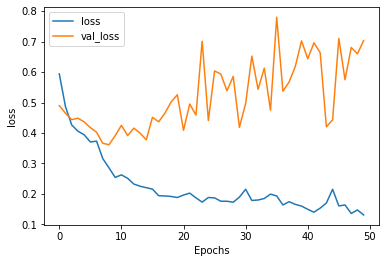

In [11]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

### Gerando arquivos para visualizar o embedding

O snippet abaixo gera dois arquivos que podem ser visualizados se upados em https://projector.tensorflow.org

*TODO*: implementar `projector` de `tensorboard.plugins`

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, weights.shape[0]):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    
out_v.close()
out_m.close()

In [13]:
generate_embeddings = lambda predict_sequences: pad_sequences(
    tokenizer.texts_to_sequences(predict_sequences), 
    padding=padding_type, 
    truncating=trunc_type, 
    maxlen=padding_max_len)

predict_on = generate_embeddings([
    'Hoje é o aniversário do meu filho', 
    'oi gnt hj é meu niver', 
    'oi gnt hj não é meu niver'])

prediction = model.predict(predict_on)

print(prediction)

[[4.9328065e-04]
 [5.9200281e-01]
 [8.1931300e-02]]


### Exportando para tensorflow.js

In [14]:
%%capture
!pip install tensorflowjs
import json
import tensorflowjs as tfjs

In [15]:
def export_model(m, words_vocab):
    tfjs.converters.save_keras_model(m, './__generated__')

    with open("./__generated__/config.ts", 'w') as f:
        f.write('export const vocabulary_size = {};\n\n'.format(vocab_size))
        f.write('export const oov_token = "{}";\n\n'.format(oov_token))
        f.write('export const padding_type = "{}";\n\n'.format(padding_type))
        f.write('export const trunc_type = "{}";\n\n'.format(trunc_type))
        f.write('export const padding_max_len = {};\n\n'.format(padding_max_len))
        f.write('export const vocabulary = {\n')
        for (index, l) in enumerate(json.dumps(words_vocab)[1:-1].split(",")):
            if index < vocab_size:
                f.write("  "+l+',\n')
        f.write('};\n')

In [16]:
export_model(model, word_index)

/usr/local/lib/python3.6/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)
